In [198]:
%matplotlib inline
import pandas as pd
import numpy as np
import json
import xml.etree.ElementTree as et
import nltk
from nltk import sent_tokenize, word_tokenize, pos_tag
from nltk.corpus import stopwords
from nltk.collocations import *
from itertools import combinations
import seaborn as sns
import os
import sys

In [139]:
reload(sys)  
sys.setdefaultencoding('utf8')

In [4]:
#load xml to dataframe
tree = et.parse("../data/AviationData.xml")
root = tree.getroot()
events_list = [i.attrib for i in root[0]]
df_events = pd.DataFrame(events_list)
df_events.head()

,AccidentNumber,AirCarrier,AircraftCategory,AircraftDamage,AirportCode,AirportName,AmateurBuilt,BroadPhaseOfFlight,Country,EngineType,...,PublicationDate,PurposeOfFlight,RegistrationNumber,ReportStatus,Schedule,TotalFatalInjuries,TotalMinorInjuries,TotalSeriousInjuries,TotalUninjured,WeatherCondition
0,GAA15CA244,,,,,,,,United States,,...,,,N786AB,Preliminary,,,,,,
1,CEN15LA392,,Airplane,Substantial,IWS,WEST HOUSTON,No,LANDING,United States,,...,09/04/2015,Instructional,N452CS,Preliminary,,,,,2,VMC
2,GAA15CA246,,,,,,,,United States,,...,,,N112RP,Preliminary,,,,,,
3,GAA15CA243,,,,,,,,United States,,...,,,N8404X,Preliminary,,,,,,
4,GAA15CA242,,,,,,,,United States,,...,,,N5255G,Preliminary,,,,,,


In [5]:
nar_list = []
filelist = [name for name in os.listdir("../data/") if name.endswith(".json")]
for f in filelist:
    with open(os.path.join("../data/", f)) as json_file:
        j = json.load(json_file)['data']
        nar_list += j
df_nar = pd.DataFrame(nar_list)

In [6]:
df_combined = pd.merge(df_events, df_nar,how='left',on='EventId')

In [7]:
df_combined.shape

(77257, 33)

In [8]:
#filter only records with probable cause
df_pc = df_combined[(df_combined['probable_cause']!='')]

In [9]:
df_pc.shape

(50503, 33)

In [10]:
df_pc.head()

,AccidentNumber,AirCarrier,AircraftCategory,AircraftDamage,AirportCode,AirportName,AmateurBuilt,BroadPhaseOfFlight,Country,EngineType,...,RegistrationNumber,ReportStatus,Schedule,TotalFatalInjuries,TotalMinorInjuries,TotalSeriousInjuries,TotalUninjured,WeatherCondition,narrative,probable_cause
175,GAA15CA208,,Airplane,Substantial,OVO,NORTH VERNON,No,LANDING,United States,Reciprocating,...,N133VU,Probable Cause,,,,,1,VMC,NTSB investigators used data provided by vario...,The pilot's failure to maintain pitch control ...
183,GAA15CA197,,Helicopter,Substantial,,N/A,No,LANDING,United States,Reciprocating,...,N58397,Probable Cause,,,,,2,VMC,NTSB investigators used data provided by vario...,The non-helicopter rated pilot's improper land...
203,GAA15CA189,,Airplane,Substantial,U660,Hidden Splendor,No,TAKEOFF,United States,Reciprocating,...,N735JB,Probable Cause,,,,,2,VMC,NTSB investigators used data provided by vario...,The pilot's failure to maintain directional co...
205,ERA15CA272,,Airplane,Substantial,DVK,Stuart Powell Field,Yes,GO-AROUND,United States,Reciprocating,...,N31CS,Probable Cause,,,1,,,VMC,NTSB investigators used data provided by vario...,"The pilot's inaccurate fuel planning, which re..."
217,WPR15CA214,,Airplane,Substantial,K69S,Avey Field,No,LANDING,United States,Reciprocating,...,C-GDYN,Probable Cause,,,1,,,VMC,NTSB investigators used data provided by vario...,The pilot's inadequate decision to continue th...


## Overall Text Analysis

In [11]:
pc_list = df_pc['probable_cause'].tolist()
pc_list = [i for i in pc_list]
pc_string = str(''.join(pc_list))
pc_string = unicode(pc_string, errors='replace')

In [12]:
pc_string = pc_string.replace(u"\u2018", "'").replace(u"\u2019", "'")

In [13]:
sw = stopwords.words('english')
tokens = nltk.word_tokenize(pc_string)
text = nltk.Text(tokens)
words = [w.lower() for w in text if w.isalpha()]
words = [w for w in words if w not in sw]

In [14]:
#words and bigram
fd = nltk.FreqDist(words)
bi_fd = nltk.FreqDist(nltk.bigrams(words))

In [15]:
fd.most_common(30)

[(u'pilot', 41897),
 (u'failure', 28745),
 (u'landing', 17154),
 (u'maintain', 15560),
 (u'control', 12881),
 (u'loss', 12856),
 (u'resulted', 12614),
 (u'accident', 12037),
 (u'engine', 11589),
 (u'factor', 10112),
 (u'power', 9648),
 (u'fuel', 9482),
 (u'inadequate', 9131),
 (u'factors', 9069),
 (u'contributing', 8705),
 (u'flight', 8367),
 (u'airplane', 8048),
 (u'improper', 7994),
 (u'due', 7596),
 (u'terrain', 7433),
 (u'conditions', 6257),
 (u'aircraft', 5752),
 (u'directional', 5461),
 (u'resulting', 4973),
 (u'lack', 4789),
 (u'takeoff', 4635),
 (u'runway', 4552),
 (u'undetermined', 4339),
 (u'airspeed', 4004),
 (u'subsequent', 3827)]

In [16]:
bigram_measures = nltk.collocations.BigramAssocMeasures()

In [17]:
finder = BigramCollocationFinder(fd, bi_fd)

In [18]:
finder.nbest(bigram_measures.raw_freq,30)

[(u'pilot', u'failure'),
 (u'failure', u'maintain'),
 (u'loss', u'engine'),
 (u'engine', u'power'),
 (u'directional', u'control'),
 (u'contributing', u'accident'),
 (u'maintain', u'directional'),
 (u'pilot', u'inadequate'),
 (u'pilot', u'improper'),
 (u'accident', u'pilot'),
 (u'power', u'due'),
 (u'forced', u'landing'),
 (u'failure', u'pilot'),
 (u'maintain', u'adequate'),
 (u'landing', u'gear'),
 (u'student', u'pilot'),
 (u'undetermined', u'reasons'),
 (u'control', u'airplane'),
 (u'factor', u'accident'),
 (u'fuel', u'exhaustion'),
 (u'control', u'landing'),
 (u'power', u'undetermined'),
 (u'contributing', u'factor'),
 (u'pilot', u'maintain'),
 (u'inadequate', u'preflight'),
 (u'contributing', u'factors'),
 (u'aircraft', u'control'),
 (u'loss', u'control'),
 (u'resulted', u'loss'),
 (u'maintain', u'clearance')]

In [113]:
bg_list = nltk.bigrams(words)
bg_pilot = [p for p in bg_list if 'pilot' in p[0]]
bg_list = nltk.bigrams(words)
bg_instructor = [p for p in bg_list if 'instructor' in p[0]]

In [114]:
nltk.FreqDist(bg_pilot).most_common(5)

[((u'pilot', u'failure'), 12887),
 ((u'pilot', u'inadequate'), 4116),
 ((u'pilot', u'improper'), 3909),
 ((u'pilot', u'maintain'), 1745),
 ((u'pilot', u'lack'), 1528)]

In [115]:
nltk.FreqDist(bg_instructor).most_common(5)

[((u'instructor', u'inadequate'), 500),
 ((u'instructor', u'failure'), 326),
 ((u'instructor', u'pilot'), 293),
 ((u'instructor', u'delayed'), 237),
 ((u'instructor', u'improper'), 96)]

While some of the bigram above doesn't exactly make sense grammatically, this happens because of the removal of stopwords. (aircraft,control) originally was most likely to be "aircraft out of control".

Based on the bigram generated from the overall text, accidents where pilot's or instructor's error is a contributing factor can be detected based on the bigrams ((pilot, instructor),(failure,inadequate,improper))

## Apply tokenization to Dataframe

In [19]:
#create a common tokenization function
def colTokenize(x):
    text = nltk.Text(nltk.word_tokenize(x.replace(u"\u2018", "'").replace(u"\u2019", "'")))
    #remove numeric and punctuation
    words = [w.lower() for w in text if w.isalpha()]
    #remove stopwords
    words = [w for w in words if w not in sw]
    return words

In [20]:
df_pc['pc_tokens'] = df_pc['probable_cause'].apply(lambda x: colTokenize(x))

In [21]:
df_pc['pc_bigram'] = df_pc['pc_tokens'].apply(lambda x: list(nltk.bigrams(x)))

In [22]:
df_pc['pc_bigram'].head()

175    [(pilot, failure), (failure, maintain), (maint...
183    [(rated, pilot), (pilot, improper), (improper,...
203    [(pilot, failure), (failure, maintain), (maint...
205    [(pilot, inaccurate), (inaccurate, fuel), (fue...
217    [(pilot, inadequate), (inadequate, decision), ...
Name: pc_bigram, dtype: object

In [122]:
words_arr = []
for i in ['pilot','instructor']:
    for j in ['inadequate','failure','improper']:
        words_arr.append((i,j))

In [23]:
def isinwords(x,words):
    found = [b for b in x if b in words]
    if found:
        return 1

In [124]:
#pc_pilot = [('pilot','inadequate'),('pilot','failure'),('pilot','improper')]
#test for token
df_pc['factor_human'] = df_pc['pc_bigram'].apply(lambda x: isinwords(x,words_arr))

In [125]:
df_pc[(df_pc['factor_human']==1)]['factor_human'].sum()

20388.0

### Finding
Out of 50,503 records of probable cause, human factor is involved in 36,048 (40%) of them!

Is this constant across years?

In [126]:
df_pc['EventDate'] = pd.to_datetime(df_pc['EventDate'])
df_pc['PublicationDate'] = pd.to_datetime(df_pc['PublicationDate'])

In [127]:
df_pc['factor_nonhuman'] = df_pc['factor_human'].apply(lambda x: val_inverse(x))
df_pc_h = df_pc[['factor_human','factor_nonhuman']].groupby(df_pc['EventDate'].map(lambda x: x.year)).sum()
df_pc_h['pct_factor_human'] = df_pc_h['factor_human']/(df_pc_h['factor_human']+df_pc_h['factor_nonhuman'])
df_pc_h['pct_factor_nonhuman'] = 1-df_pc_h['pct_factor_human']

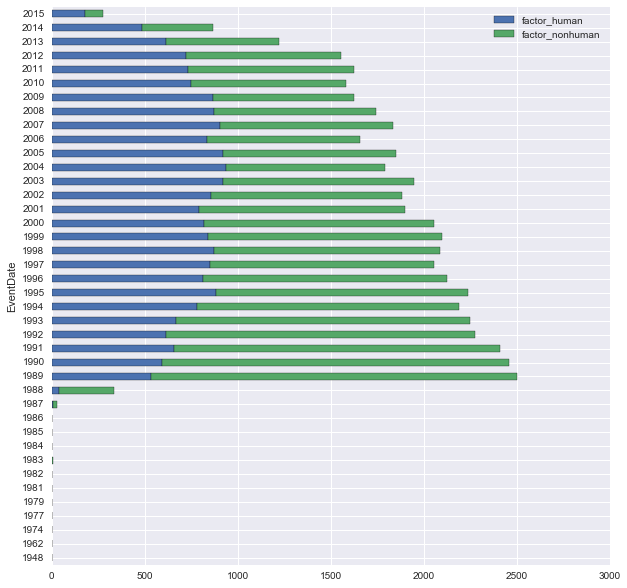

In [158]:
df_pc_h[['factor_human','factor_nonhuman']].plot.barh(stacked=True,figsize=(10,10))

,factor_human,factor_nonhuman,pct_factor_human,pct_factor_nonhuman
EventDate,,,,
1989,533.0,1970.0,0.212944,0.787056
1990,591.0,1868.0,0.240342,0.759658
1991,656.0,1754.0,0.272199,0.727801
1992,617.0,1658.0,0.271209,0.728791
1993,671.0,1577.0,0.298488,0.701512
1994,783.0,1405.0,0.357861,0.642139
1995,883.0,1355.0,0.394549,0.605451
1996,813.0,1312.0,0.382588,0.617412
1997,854.0,1204.0,0.414966,0.585034


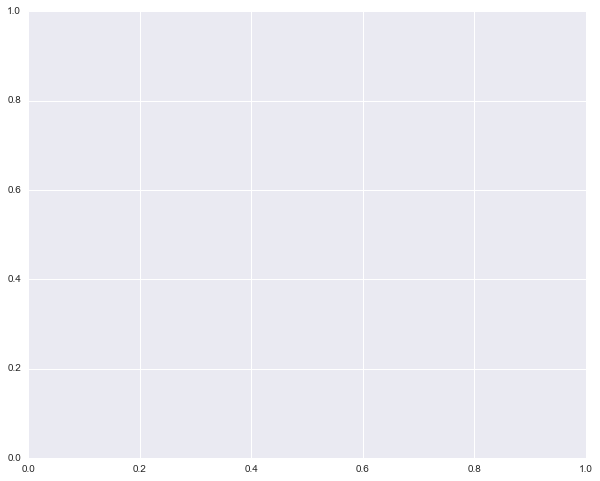

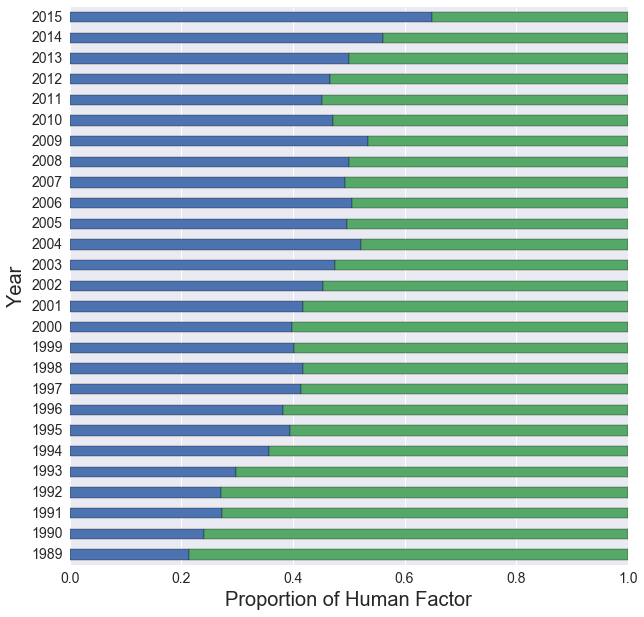

In [226]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = df_pc_h.iloc[df_pc_h.index>1988][['pct_factor_human','pct_factor_nonhuman']].plot.barh(stacked=True,figsize=(10,10))
ax.tick_params(labelsize=14)
ax.set_xlabel('Proportion of Human Factor', fontsize=20)
ax.set_ylabel('Year', fontsize=20)

Turns out accidents with human factor makes up an increasing share of total accidents over year. Is this because planes are getting more reliable, as reflected by decreasing overall number of accidents?

In [142]:
#how about weather?
df_pc['factor_weather'] = df_pc['pc_tokens'].apply(lambda x: isinwords(x,['weather']))

In [143]:
df_pc['factor_weather'].sum()
#thats small!

2136.0

However, as shown in the initial exploration, the dataset is mostly comprised of small aircraft for personal flight. What if we separate these? Is there a difference in the cause of accidents on small general aviation versus commercial flights?

In [204]:
df_pc['Factor'] = np.where(df_pc['factor_human']==1,'Human', 'Others')

In [205]:
df_pc['FlightType'] = np.where(((df_pc.NumberOfEngines > 1)&(df_pc.EngineType=="Turbo Fan")|(df_pc.EngineType=="Turbo Jet")|(df_pc.EngineType=="Turbo Prop")), 'Commercial', 'Non-commercial')

In [208]:
pd.crosstab(df_pc.Factor,df_pc.FlightType).apply(lambda x: x*100/x.sum(),axis=0)

FlightType,Commercial,Non-commercial
Factor,,
Human,21.260786,42.090609
Others,78.739214,57.909391


Human factors plays a much bigger part (42%) in non-commercial flights compared to commercial ones (21%)

In [191]:
df_comp = df_pc[['factor_human','factor_nonhuman']].groupby([df_pc['personal_flag'],df_pc['EventDate'].map(lambda x: x.year)]).sum()
df_comp['pct_factor_human'] = df_comp['factor_human']/(df_comp['factor_human']+df_comp['factor_nonhuman'])
df_comp['pct_factor_nonhuman'] = 1-df_comp['pct_factor_human']

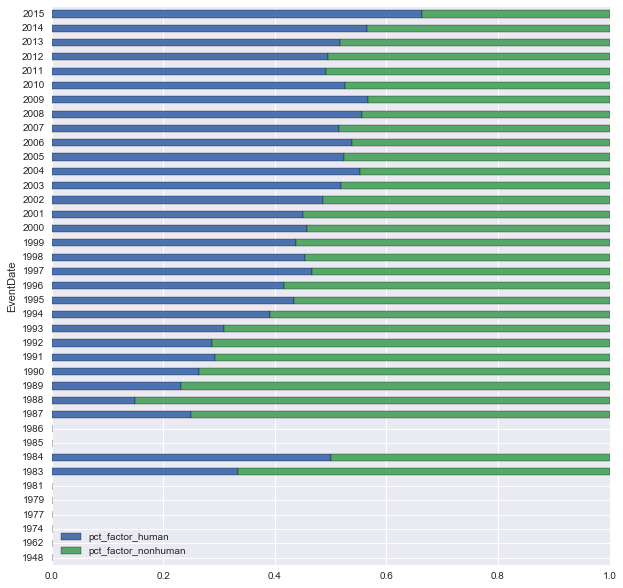

In [193]:
df_comp.ix["Personal"][['pct_factor_human','pct_factor_nonhuman']].plot.barh(stacked=True,figsize=(10,10))

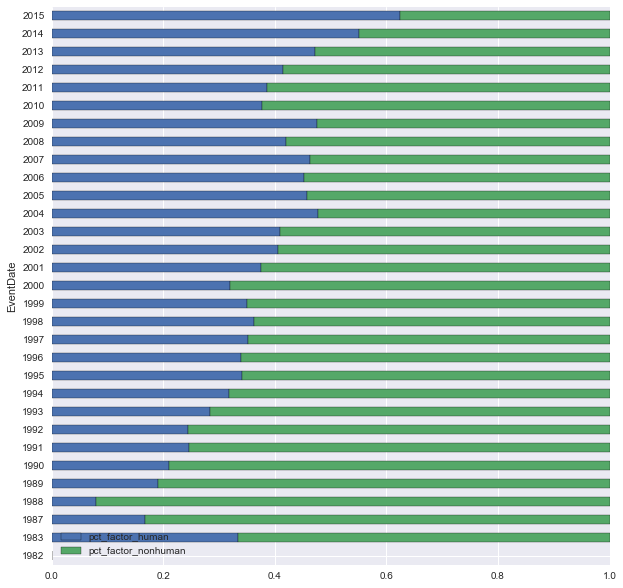

In [194]:
df_comp.ix["Others"][['pct_factor_human','pct_factor_nonhuman']].plot.barh(stacked=True,figsize=(10,10))

### Now moving on to the narrative text...

In [144]:
nar_list = df_pc['narrative'].tolist()
nar_list = [i for i in nar_list]
nar_tokens = colTokenize(str(''.join(nar_list)))

In [145]:
n_fd = nltk.FreqDist(nar_tokens)

In [146]:
n_bg = nltk.bigrams(nar_tokens)

In [147]:
n_fd_bg = nltk.FreqDist(n_bg)

In [148]:
n_fd_bg.most_common(10)

[((u'support', u'investigation'), 49606),
 ((u'used', u'data'), 49602),
 ((u'prepare', u'aircraft'), 48917),
 ((u'aircraft', u'accident'), 48376),
 ((u'various', u'sources'), 41490),
 ((u'traveled', u'support'), 41489),
 ((u'data', u'provided'), 41408),
 ((u'provided', u'various'), 41383),
 ((u'sources', u'prepare'), 40074),
 ((u'may', u'traveled'), 33266)]

In [149]:
df_pc['narrative'].head(10)
#hmm, there's a pattern here

175    NTSB investigators used data provided by vario...
183    NTSB investigators used data provided by vario...
203    NTSB investigators used data provided by vario...
205    NTSB investigators used data provided by vario...
217    NTSB investigators used data provided by vario...
222    NTSB investigators used data provided by vario...
234    NTSB investigators used data provided by vario...
240    NTSB investigators used data provided by vario...
244    NTSB investigators used data provided by vario...
246    NTSB investigators used data provided by vario...
Name: narrative, dtype: object

In [150]:
df_pc['nar_header'] = df_pc['narrative'].apply(lambda x: x.split('.')[0])

In [155]:
ntsb_nar =  [i for i in list(df_pc['nar_header'].unique()) if 'NTSB' in i]
ntsb_nar    

[u'NTSB investigators used data provided by various entities, including, but not limited to, the Federal Aviation Administration and/or the operator and did not travel in support of this investigation to prepare this aircraft accident report',
 u'NTSB investigators may not have traveled in support of this investigation and used data provided by various sources to prepare this aircraft accident report',
 u'NTSB investigators either traveled in support of this investigation or conducted a significant amount of investigative work without any travel, and used data obtained from various sources to prepare this aircraft accident report',
 u'NTSB investigators used data provided by various sources and may not have traveled in support of this investigation to prepare this aircraft incident report',
 u'NTSB investigators traveled in support of this investigation and used data obtained from various sources to prepare this aircraft accident report',
 u'NTSB investigators may not have traveled in 